## **INITIALIZATIONS - ALL CODES UNDER THIS TO BE RUN**

**Importing libraries**

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0+cu101


**Unzipping the dataset.zip file**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/dataset.zip"

**Creating custom Dataset**

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = "/content/COVID-19 Radiography Database"
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)



In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)



In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(train_transform)

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)




**Prepare DataLoader**

In [ ]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [ ]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)


Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6


dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))



Number of training batches 470
Number of test batches 15


**Data Visualisation**

In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    acc=6
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            acc-=1

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
    #print("Accuracy= "+str(acc/6))

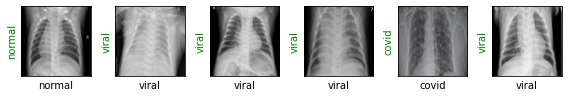

In [ ]:
images1, labels1 = next(iter(dl_train))
show_images(images1, labels1, labels1)
#print(images1)

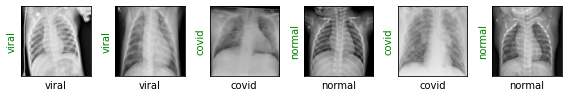

In [ ]:
images2, labels2 = next(iter(dl_test))
show_images(images2, labels2, labels2)

**Creating the model - IMPORTANT**

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
#print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

# **Training using RESNET MODEL (NOT NECESSARY FOR TERMWORK)**

**Training the resnet18 model and classifying**

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.8962, Accuracy: 0.6000


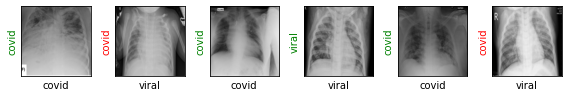

Evaluating at step 20
Validation Loss: 0.8480, Accuracy: 0.6111


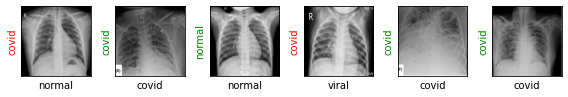

Evaluating at step 40
Validation Loss: 0.3907, Accuracy: 0.8667


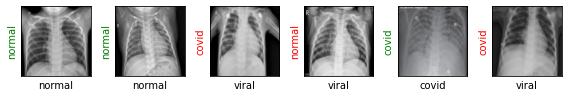

Evaluating at step 60
Validation Loss: 0.2208, Accuracy: 0.9444


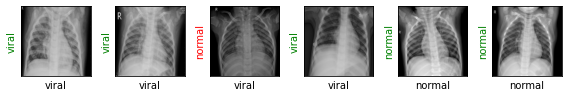

Evaluating at step 80
Validation Loss: 0.1269, Accuracy: 0.9667


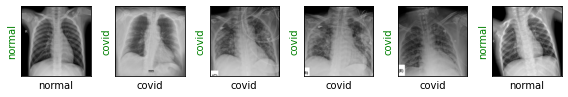

Performance condition satisfied, stopping..
CPU times: user 3min 1s, sys: 2.31 s, total: 3min 3s
Wall time: 3min 3s


In [ ]:
%%time

train(epochs=1)

# **TERM WORK -1**

**Feature Extraction - Term work 1**

In [ ]:
import pandas as pd
df = pd.DataFrame()

In [ ]:
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
for _ in range(len(dl_train)):
  images1, labels1 = next(iter(dl_train))
  output = feature_extractor(images1)
  output = output.reshape(output.shape[0],output.shape[1]*output.shape[2]*output.shape[3])
  #print(output)
  toNumpy = output.detach().numpy()
  #Appending each row (image wise)
  for i in range(batch_size):
    x = toNumpy[i].reshape(1,toNumpy[0].shape[0])
    #print(x)
    feat = pd.DataFrame(x)
    #print(feat)
    df = df.append(feat)

print(df)

#f=open('feature.txt','a')
#for i in range(batch_size):
#  np.savetxt(f, toNumpy[i])
#  print(toNumpy[i])
 # f.write("\n")

         0         1         2    ...       509       510       511
0   0.812165  0.033009  1.326707  ...  0.309275  0.529087  2.128542
0   1.400222  0.906535  0.947971  ...  0.178058  2.284756  0.828393
0   0.243682  1.330959  0.617826  ...  2.483594  0.572135  0.474803
0   0.668136  2.058719  0.528152  ...  0.028544  1.959104  0.148034
0   1.289807  0.552158  1.101724  ...  0.740055  0.207029  1.206258
..       ...       ...       ...  ...       ...       ...       ...
0   0.633512  1.937623  0.570077  ...  0.241468  2.393476  0.846260
0   1.505400  0.493351  0.375378  ...  0.121210  0.169917  0.540455
0   0.639431  0.463947  1.468995  ...  0.590540  1.236912  0.495905
0   0.914584  0.751782  2.010267  ...  1.129486  0.516565  2.050596
0   0.323368  1.129022  0.165799  ...  2.165490  0.550079  0.922022

[2820 rows x 512 columns]


In [ ]:
df.to_csv('train_features.csv')

In [ ]:
df1 = pd.DataFrame()

In [ ]:

#feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
for _ in range(len(dl_test)):
  images2, labels2 = next(iter(dl_test))
  output1 = feature_extractor(images2)
  output1 = output1.reshape(output1.shape[0],output1.shape[1]*output1.shape[2]*output1.shape[3])
  #print(output)
  toNumpy = output1.detach().numpy()
  #Appending each row (image wise)
  for i in range(batch_size):
    x = toNumpy[i].reshape(1,toNumpy[0].shape[0])
    #print(x)
    feat = pd.DataFrame(x)
    #print(feat)
    df1 = df1.append(feat)

print(df1)

         0         1         2    ...       509       510       511
0   1.553120  0.841162  0.589003  ...  1.261236  0.640783  0.642548
0   0.774222  0.970611  0.340264  ...  0.543711  2.502839  1.228158
0   0.824685  1.007909  0.183622  ...  0.153476  0.254694  0.481959
0   0.305080  1.374649  1.280345  ...  1.562516  1.774665  1.015661
0   1.603023  0.552678  2.395679  ...  1.363762  0.139385  2.074955
..       ...       ...       ...  ...       ...       ...       ...
0   0.856081  0.806764  1.021236  ...  0.540197  1.400670  1.684014
0   0.783187  2.428282  0.272884  ...  0.485314  1.138219  0.263533
0   1.648992  0.580057  1.186809  ...  0.726680  0.485685  0.895046
0   0.887672  0.711915  0.527875  ...  0.089292  1.917172  1.181533
0   0.196010  0.543172  1.473428  ...  1.152976  0.107253  0.151845

[90 rows x 512 columns]


In [ ]:
df1.to_csv('test_features.csv')

**Feature Map for 1 batch of training images - Term work 1**

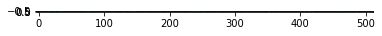

In [ ]:
images1, labels1 = next(iter(dl_train))
output = feature_extractor(images1)
output = output.reshape(output.shape[0],output.shape[1]*output.shape[2]*output.shape[3])
toNumpy = output.detach().numpy()
plt.imshow(toNumpy)
for i in range(batch_size):

  x = toNumpy[i].reshape(1,toNumpy[0].shape[0])
  plt.imshow(x)

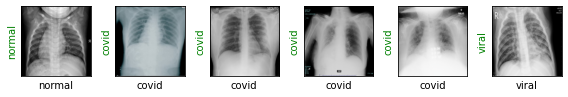

In [ ]:
show_images(images1,labels1,labels1)

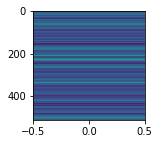

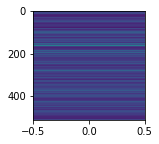

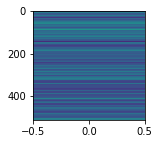

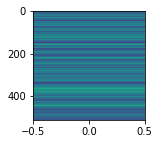

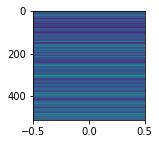

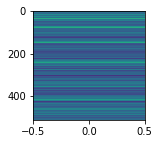

In [ ]:
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
for p in feature_extractor.parameters():
    p.requires_grad = False


out = feature_extractor(images1)
out = torch.squeeze(out, 0)
for i in range(batch_size):
  feature = out[i].numpy()
  feature = feature.reshape(feature.shape[0],1)
 # imshow(random.rand(8, 90), interpolation='nearest')
  plt.figure(figsize = (2,2))
  plt.imshow(feature, aspect='auto')
  plt.show()

**Testing for all 15 test batches - Term work 1**

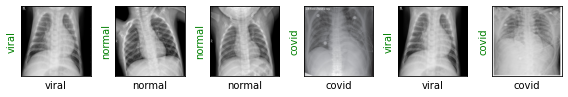

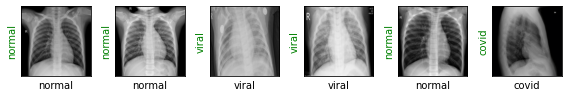

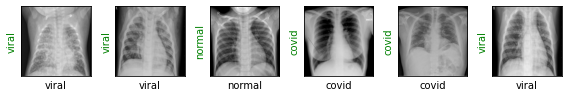

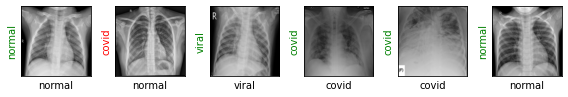

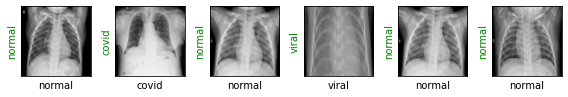

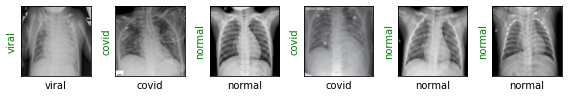

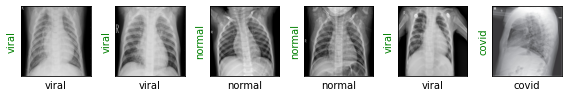

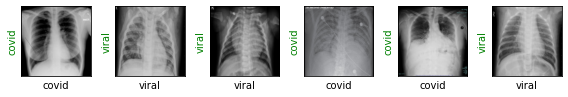

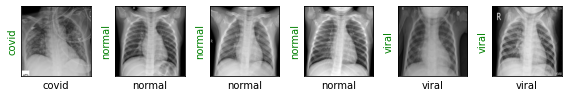

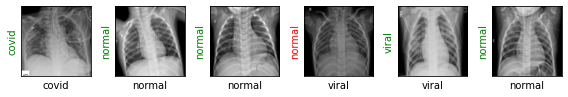

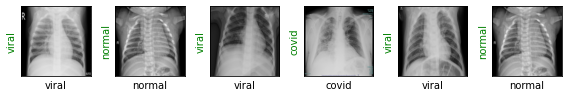

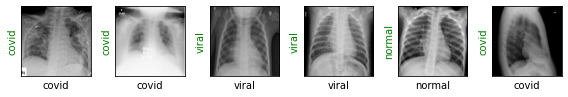

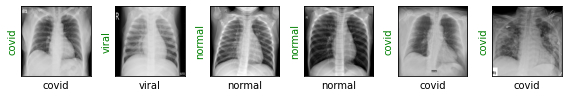

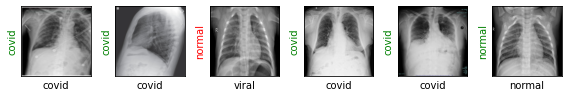

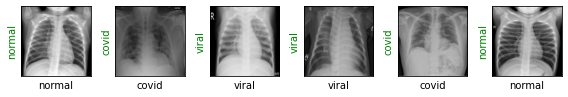

In [ ]:
for _ in range(len(dl_test)):
  show_preds()

**SVM Classifier - Term work 1**

In [ ]:
batch_size_train = 1000
batch_size_test = 90


dl_train1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dl_test1 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

print('Number of training batches', len(dl_train1))
print('Number of test batches', len(dl_test1))


Number of training batches 3
Number of test batches 1


In [ ]:
images1, labels1 = next(iter(dl_train1))
output = feature_extractor(images1)
output = output.reshape(output.shape[0],output.shape[1]*output.shape[2]*output.shape[3])
X_train = output.detach().numpy()
y_train = labels1.detach().numpy()
y_train = y_train.reshape(y_train.shape[0],1)

#Appending each row (image wise)

images2, labels2 = next(iter(dl_test1))
output = feature_extractor(images2)
output = output.reshape(output.shape[0],output.shape[1]*output.shape[2]*output.shape[3])
X_test = output.detach().numpy()
y_test = labels2.detach().numpy()
y_test = y_test.reshape(y_test.shape[0],1)


In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)
#print(y_pred.shape)
#print(y_pred)
#print(y_test.shape)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.9666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Feature Selection Using RFE - Term work 1**

In [ ]:
from sklearn.feature_selection import RFE
selector = RFE(estimator=clf, n_features_to_select = 150, step=1)
selector = selector.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
selector.ranking_

array([217, 124,  61, 147, 324, 212,   1,   1,   1, 177,   1, 114,   1,
        46,   1,  14,  92, 171, 303,   1, 180, 241,   1, 197, 239,  98,
       323,  69, 223, 157,  81,   1,  73, 172, 297,   1, 299,   1,   1,
         1,  26, 257,   1,   1,  65,   1,  79,   1,  63,   1,  48, 105,
       110, 230,  75,   1, 181, 187, 344,  67, 107, 196,   1, 146,   1,
       205, 263, 203,   1, 250, 242,  97,   1, 327, 335, 338,  35, 349,
       320,  59,  68, 170,  76,   1, 247,   1,  42,   1,   1, 310,   1,
         1,  38, 282,   1,   1,   9,  28, 134, 103, 284, 136, 267,   1,
         1, 225, 301, 138, 102,   1, 167, 118, 215, 356,   1, 317,  72,
       302,   1,   1, 129,   1, 260,   1, 254, 178, 336,   1, 185, 139,
        51,  10,   1,  89, 123,   1,  27,   1, 119,   1, 352, 207,   1,
       357, 159, 122, 176, 273, 175, 186,  34,   1, 269, 183, 245, 290,
        21, 188,   1, 321,  24,   1,   1, 127,  58,   1,   1, 130, 144,
       306, 270, 360, 328,   1, 277,  41, 334, 293, 330, 255, 29

In [ ]:
selector.support_

array([False, False, False, False, False, False,  True,  True,  True,
       False,  True, False,  True, False,  True, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True,  True, False,  True, False,  True, False, False,
       False,  True,

In [ ]:
y_fs_pred = selector.predict(X_test)
y_fs_pred = y_fs_pred.reshape(y_fs_pred.shape[0],1)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9666666666666667


**Confusion Matrix - Term work 1**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_fs_pred)

array([[34,  2,  0],
       [ 0, 22,  1],
       [ 0,  0, 31]])

Confusion matrix, without normalization
[[34  2  0]
 [ 0 22  1]
 [ 0  0 31]]
Normalized confusion matrix
[[0.94444444 0.05555556 0.        ]
 [0.         0.95652174 0.04347826]
 [0.         0.         1.        ]]


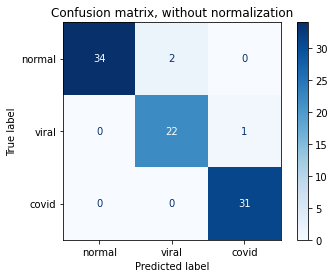

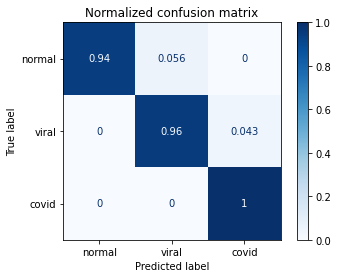

In [ ]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(selector, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fs_pred, target_names=class_names))

              precision    recall  f1-score   support

      normal       1.00      0.94      0.97        36
       viral       0.92      0.96      0.94        23
       covid       0.97      1.00      0.98        31

    accuracy                           0.97        90
   macro avg       0.96      0.97      0.96        90
weighted avg       0.97      0.97      0.97        90



**Plotting ROCs - Term work 1**

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
y_tr = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_tr.shape[1]

y_te = label_binarize(y_test, classes=[0, 1, 2])

In [ ]:
print(n_classes)
print(y_te.shape)

3
(90, 3)


In [ ]:
# Learn to predict each class against the other
#random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_tr).decision_function(X_test)
print(y_score)

[[ 1.70195627 -2.02559367 -2.30284338]
 [-1.78785685  1.26152742 -1.21161997]
 [ 1.84069955 -1.0371986  -2.47921306]
 [-3.66558949  2.31580039 -2.12491551]
 [-1.64226446  0.38389404 -1.01164783]
 [ 3.48541406 -3.14161737 -1.9800489 ]
 [-2.8858275   1.89291786 -1.71168545]
 [-3.4657936  -2.99665906  1.67598283]
 [-3.61620188  2.592718   -2.90257102]
 [-5.43540446 -2.1813663   3.19567254]
 [ 0.54949448 -0.41595357 -1.93296914]
 [ 0.65180126 -1.12978487 -1.513076  ]
 [ 1.84069955 -1.0371986  -2.47921306]
 [-2.98360257  2.20301652 -1.69223218]
 [-3.06927299 -1.63255651  1.34922027]
 [-2.1744494  -1.49751768  1.44102493]
 [ 3.58719534 -3.33202942 -1.47522896]
 [ 3.86395054 -3.52109077 -2.04590404]
 [ 1.51394362 -2.45163244 -1.76304906]
 [ 1.43062226 -1.02335275 -2.40712284]
 [-4.42806726  4.28805403 -3.34732448]
 [ 1.96574162 -2.94511172 -1.50592659]
 [-1.02874114 -0.00664824 -0.75258263]
 [-1.99418584 -0.29363798  0.57888377]
 [ 0.54949448 -0.41595357 -1.93296914]
 [-1.99418584 -0.29363798

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
print(tpr)

{0: array([0.        , 0.02777778, 0.05555556, 0.13888889, 0.19444444,
       0.30555556, 0.36111111, 0.38888889, 0.44444444, 0.55555556,
       0.66666667, 0.69444444, 0.91666667, 0.94444444, 0.94444444,
       0.97222222, 0.97222222, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ]), 1: array([0.        , 0.04347826, 0.13043478, 0.43478261, 0.52173913,
       0.56521739, 0.65217391, 0.91304348, 0.95652174, 0.95652174,
       0.95652174, 0.95652174, 0.95652174, 0.95652174, 0.95652174,
       0.95652174, 0.95652174, 0.95652174, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1. 

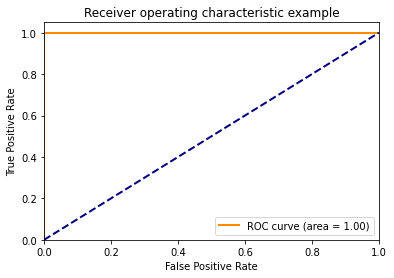

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


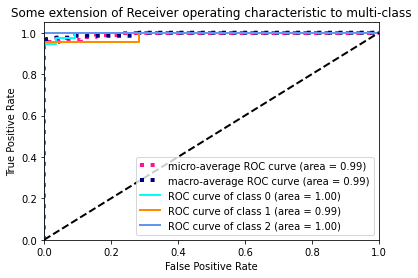

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_te, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_te, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_te, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_te, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))


One-vs-One ROC AUC scores:
0.994690 (macro),
0.995409 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.994690 (macro),
0.995409 (weighted by prevalence)


# **TERM WORK - 2**

**Understanding the significane of C parameter - Term work 2**

In [ ]:
feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])

In [ ]:
batch_size_train = 200
batch_size_test = 90


dl_train1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dl_test1 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

print('Number of training batches', len(dl_train1))
print('Number of test batches', len(dl_test1))


Number of training batches 15
Number of test batches 1


In [ ]:
images1, labels1 = next(iter(dl_train1))
output = feature_extractor(images1)
output = output.reshape(output.shape[0],output.shape[1]*output.shape[2]*output.shape[3])
X_train = output.detach().numpy()
y_train = labels1.detach().numpy()
y_train = y_train.reshape(y_train.shape[0],1)

#Appending each row (image wise)

images2, labels2 = next(iter(dl_test1))
output = feature_extractor(images2)
output = output.reshape(output.shape[0],output.shape[1]*output.shape[2]*output.shape[3])
X_test = output.detach().numpy()
y_test = labels2.detach().numpy()
y_test = y_test.reshape(y_test.shape[0],1)

In [ ]:
qwer = [0.001, 0.01, 0.1, 1, 10]
yval =[]

In [ ]:
from sklearn import svm

for x in qwer:

  #Create a svm Classifier
  clf = svm.SVC(C=x,kernel='linear') #Kernel

  #Train the model using the training sets
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_test)
  y_pred = y_pred.reshape(y_pred.shape[0],1)

  #Import scikit-learn metrics module for accuracy calculation
  from sklearn import metrics

  # Model Accuracy: how often is the classifier correct?
  yval.append(metrics.accuracy_score(y_test, y_pred))
  #print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
from pandas import DataFrame
Data ={'C Values': [0.001, 0.01, 0.1, 1.0, 10.0],'Accuracy': yval}
df = DataFrame(Data,columns=['C Values','Accuracy'])
print(df)

   C Values  Accuracy
0     0.001  0.933333
1     0.010  0.977778
2     0.100  0.966667
3     1.000  0.966667
4    10.000  0.966667


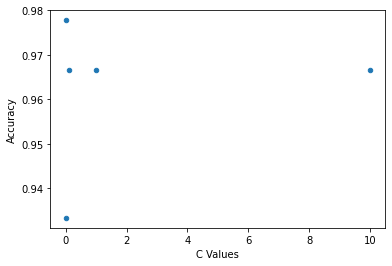

In [ ]:
df.plot(x ='C Values', y='Accuracy', kind = 'scatter')
plt.show()

Using different Kernels

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.9555555555555556


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
clf = svm.SVC(kernel='poly') #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.9555555555555556


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Create a svm Classifier
clf = svm.SVC(C=1.0,kernel='poly',degree = 1) #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.3111111111111111


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
clf = svm.SVC(kernel='poly', degree=5) #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.9111111111111111


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Create a svm Classifier
clf = svm.SVC(C=1.0,kernel='rbf') #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.9666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Create a svm Classifier
clf = svm.SVC(C=1.0,kernel='sigmoid') #Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Upon usingg SVM classifier:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Upon usingg SVM classifier:
Accuracy: 0.7666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Understanding KNN Classification**

With different number of neighbours

In [ ]:
#using n_neighbours = 3
xv=[]
yv=[]
for i in range(3,33,3):
  xv.append(i)
  from sklearn.neighbors import KNeighborsClassifier
  neigh = KNeighborsClassifier(n_neighbors=i,weights='uniform')
  neigh.fit(X_train, y_train)
  yv.append(neigh.score(X_test, y_test))


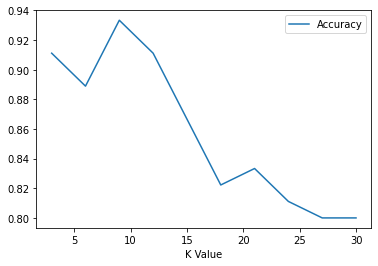

In [ ]:
Data = {'K Value': xv,
        'Accuracy': yv
       }

df = DataFrame(Data,columns=['K Value','Accuracy'])
df.plot(x ='K Value', y='Accuracy', kind = 'line')
plt.show()

In [ ]:
print(df)

   K Value  Accuracy
0        3  0.911111
1        6  0.888889
2        9  0.933333
3       12  0.911111
4       15  0.866667
5       18  0.822222
6       21  0.833333
7       24  0.811111
8       27  0.800000
9       30  0.800000


With different types of Weights

In [ ]:
#using weights = uniform (default), n_neighbors=5
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5,weights='uniform')
neigh.fit(X_train, y_train)

In [ ]:
print("Mean Accuracy:",neigh.score(X_test, y_test))

Mean Accuracy: 0.9111111111111111


In [ ]:
#using weights = distance, n_neighbors=5
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5,weights='distance')
neigh.fit(X_train, y_train)

In [ ]:
print("Mean Accuracy:",neigh.score(X_test, y_test))

Mean Accuracy: 0.9222222222222223
